## DNA Sequence Analysis and Gene Type Prediction using ML


### About this Dataset
DNA sequence prediction is a crucial task in bioinformatics, enabling researchers to analyze genetic patterns, predict mutations, and model gene structures. This dataset can be used to implement three machine learning approaches to predict nucleotide sequences

We use nucleotide sequences of human genes from the NCBI Gene Database. The dataset consists of:

1. Gene symbols, descriptions, and types.
2. Nucleotide sequences represented as A, T, C, G.
3. Train-validation split: 80% training, 20% testing

### Setting Up the Environment & Loading Libraries

In [3]:
# Import Libraries
import numpy as np
import pandas as pd

# Set matplotlib backend and inline display
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

import seaborn as sns
from tabulate import tabulate

# Scikit-learn libraries for model building and evaluation
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

### Loading Dataset

In [13]:
# Load the datasets from the current directory
train_df = pd.read_csv('../dataset/train.csv', encoding='ascii')
val_df = pd.read_csv('../dataset/validation.csv', encoding='ascii')
test_df = pd.read_csv('../dataset/test.csv', encoding='ascii')

# Display the shapes of the datasets
print('Training data shape:', train_df.shape)
print('Validation data shape:', val_df.shape)
print('Test data shape:', test_df.shape)

Training data shape: (22593, 7)
Validation data shape: (4577, 7)
Test data shape: (8326, 7)


### Data Exploration

In [14]:
# ===== Preview of Training Data =====
print("===== Preview of Training Data =====")
print(tabulate(train_df.head(), headers='keys', tablefmt='psql'))

# ===== Dataset Info =====
print("\n===== Dataset Info =====")
print(f"Shape: {train_df.shape[0]} rows × {train_df.shape[1]} columns\n")

# Summary statistics (numeric + categorical)
summary = train_df.describe(include='all').transpose()
print(tabulate(summary, headers='keys', tablefmt='psql'))

# ===== Missing Values Overview =====
missing_vals = train_df.isnull().sum()
missing_table = pd.DataFrame({
    "Column": missing_vals.index,
    "Missing Values": missing_vals.values,
    "Percentage": (missing_vals.values / len(train_df) * 100).round(2)
})
missing_table = missing_table[missing_table["Missing Values"] > 0]
if not missing_table.empty:
    print("\n===== Missing Values =====")
    print(tabulate(missing_table, headers='keys', tablefmt='psql'))
else:
    print("\nNo missing values detected.")

# ===== GeneType Distribution =====
gene_type_counts = train_df['GeneType'].value_counts()
gene_type_percent = (gene_type_counts / len(train_df) * 100).round(2)

dist_table = pd.DataFrame({
    "GeneType": gene_type_counts.index,
    "Count": gene_type_counts.values,
    "Percentage": gene_type_percent.values
})

print("\n===== GeneType Distribution =====")
print(tabulate(dist_table, headers='keys', tablefmt='psql'))

===== Preview of Training Data =====
+----+--------------+--------------+--------------+----------------------------------------------------+-------------------+-------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    |   Unnamed: 0 |   NCBIGeneID | Symbol       | Description                                        | GeneType          | GeneGroupMethod   | NucleotideSequence                                                                                                                                                                                                                                                                                        |
|----+--------------+--------------+--------------+----------------------

### Data Visulization

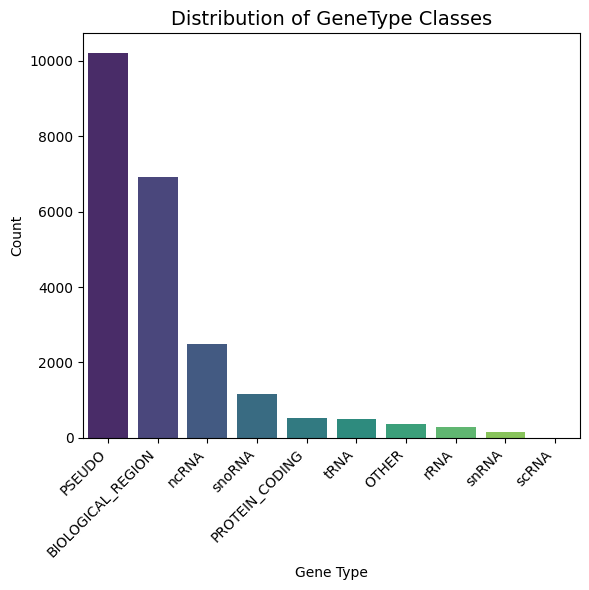

In [15]:
# ===== Visualization =====
plt.figure(figsize=(6,6))
sns.barplot(x=gene_type_counts.index, 
            y=gene_type_counts.values, 
            hue=gene_type_counts.index, 
            palette="viridis", 
            legend=False)

plt.title("Distribution of GeneType Classes", fontsize=14)
plt.xlabel("Gene Type")
plt.ylabel("Count")

# Fix label overlap
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(False)
plt.show()


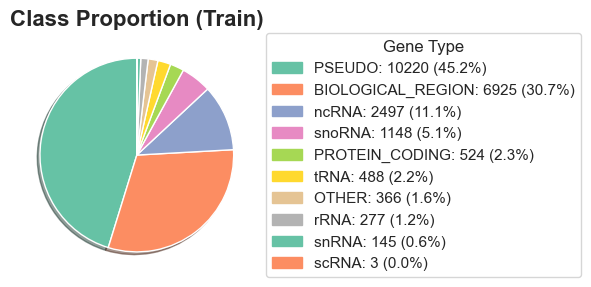

In [50]:
# Compute class counts
class_counts = train_df['GeneType'].value_counts()
classes = class_counts.index
counts = class_counts.values

# Colors for pie chart
colors = sns.color_palette("Set2", len(classes))

# --- Pie chart ---
plt.figure(figsize=(6,6))
plt.pie(counts, 
        startangle=90, 
        shadow=True, 
        colors=colors)   # No labels inside

# Title
plt.title("Class Proportion (Train)", fontsize=16, fontweight='bold')

# --- Legend with labels + percentages ---
total = counts.sum()
legend_labels = [f"{cls}: {count} ({count/total:.1%})" 
                 for cls, count in zip(classes, counts)]
patches = [mpatches.Patch(color=colors[i], label=legend_labels[i]) 
           for i in range(len(classes))]

plt.legend(handles=patches, 
           title="Gene Type", 
           loc="center left", 
           bbox_to_anchor=(1, 0.5), 
           fontsize=11)

plt.tight_layout()
plt.show()




C:\Users\muham\AppData\Local\Temp\ipykernel_30912\1889429809.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='GeneType', y='seq_length', data=train_df, palette='Spectral', inner='quartile')


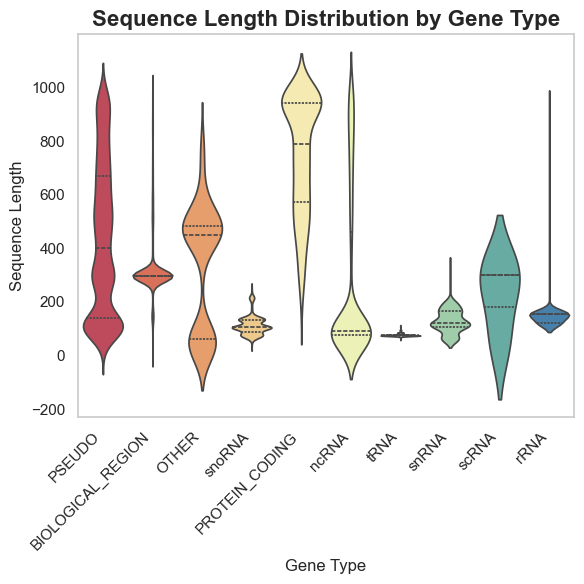

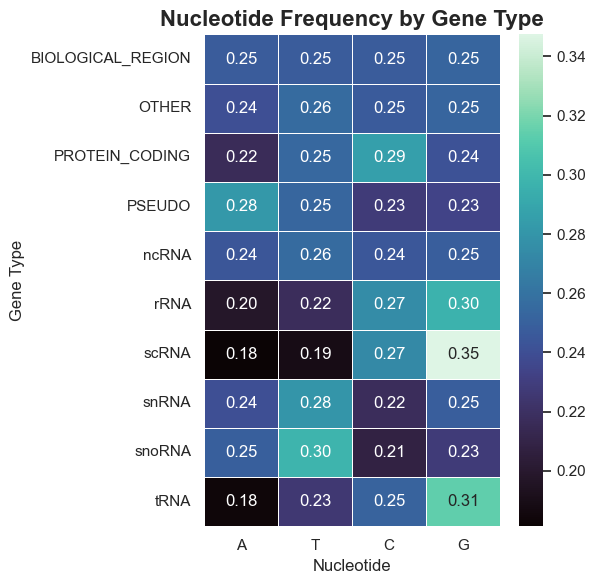

In [56]:
# Create the sequence length column if not already present
train_df['seq_length'] = train_df['NucleotideSequence'].str.len()

# Ensure seq_length column exists
train_df['seq_length'] = train_df['NucleotideSequence'].str.len()

# --- Violin Plot: Sequence Length by Gene Type ---
plt.figure(figsize=(6,6))
sns.violinplot(x='GeneType', y='seq_length', data=train_df, palette='Spectral', inner='quartile')
plt.title('Sequence Length Distribution by Gene Type', fontsize=16, weight='bold')
plt.xlabel('Gene Type', fontsize=12)
plt.ylabel('Sequence Length', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(False)
plt.tight_layout()
plt.show()

# --- Nucleotide Frequency Heatmap by Gene Type ---
nucleotides = ['A', 'T', 'C', 'G']
def nucleotide_freq(seq):
    return pd.Series({n: seq.count(n)/len(seq) for n in nucleotides})
freq_df = train_df.groupby('GeneType')['NucleotideSequence'].apply(lambda seqs: ''.join(seqs)).apply(nucleotide_freq)
plt.figure(figsize=(6,6))
sns.heatmap(freq_df, annot=True, cmap='mako', fmt='.2f', linewidths=0.5)
plt.title('Nucleotide Frequency by Gene Type', fontsize=16, weight='bold')
plt.xlabel('Nucleotide')
plt.ylabel('Gene Type')
plt.tight_layout()
plt.grid(False)
plt.show()


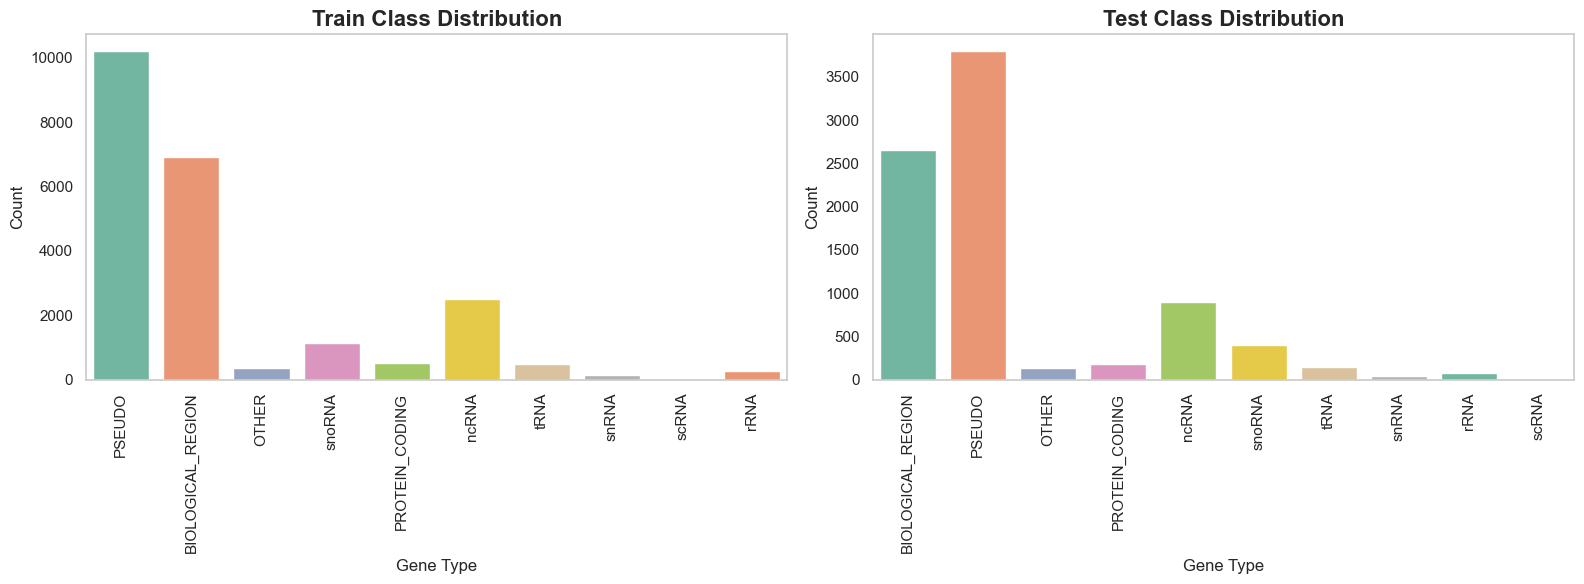

In [57]:
# --- Side-by-side class distribution plots (fixed warnings) ---
fig, ax = plt.subplots(1, 2, figsize=(16,6))

# Train data distribution
sns.countplot(x='GeneType', data=train_df, hue='GeneType', palette='Set2', legend=False, ax=ax[0])
ax[0].set_title("Train Class Distribution", fontsize=16, fontweight='bold')
ax[0].set_xlabel("Gene Type", fontsize=12)
ax[0].set_ylabel("Count", fontsize=12)
ax[0].tick_params(axis='x', rotation=90)
ax[0].grid(False)

# Test data distribution
sns.countplot(x='GeneType', data=test_df, hue='GeneType', palette='Set2', legend=False, ax=ax[1])
ax[1].set_title("Test Class Distribution", fontsize=16, fontweight='bold')
ax[1].set_xlabel("Gene Type", fontsize=12)
ax[1].set_ylabel("Count", fontsize=12)
ax[1].tick_params(axis='x', rotation=90)
ax[1].grid(False)

plt.tight_layout()
plt.show()


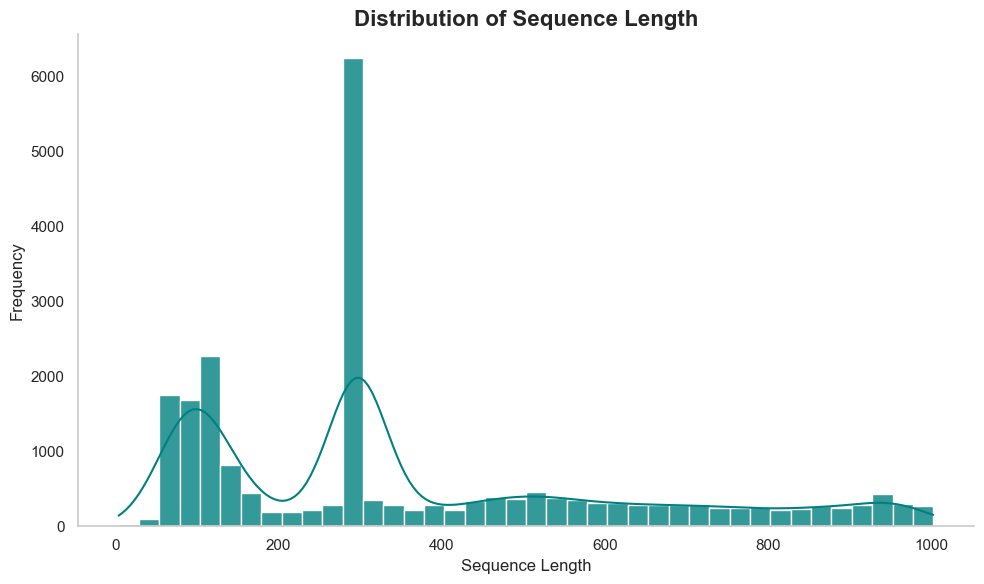

In [58]:
# Create a new column for sequence length
train_df['seq_length'] = train_df['NucleotideSequence'].str.len()

# Plot histogram with improved style
plt.figure(figsize=(10,6))
sns.histplot(
    data=train_df, 
    x='seq_length', 
    bins=40, 
    kde=True, 
    color='teal',        # solid clean color
    edgecolor=None, 
    alpha=0.8
)

plt.title('Distribution of Sequence Length', fontsize=16, weight='bold')
plt.xlabel('Sequence Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Remove grid and keep background clean
sns.despine()
plt.grid(False)

plt.tight_layout()
plt.show()

plt.show()

# Note: There are only two numeric columns ('NCBIGeneID', 'seq_length').
# Hence, we skip a correlation heatmap, which is more useful when four or more numeric columns are present.

These visualizations help reveal:
- How sequence lengths vary by gene type (violin plot).
- Whether certain gene types have compositional bias for specific nucleotides (heatmap).
You can further explore relationships by adding more numeric features or using pairplots if available.

### Data Cleaning and Preprocessing
- Handle missing values by removing rows with null entries.
- Standardize nucleotide sequences to uppercase.

In [33]:
# Drop unnecessary column
for df in [train_df, val_df, test_df]:
    if 'Unnamed: 0' in df.columns:
        df.drop('Unnamed: 0', axis=1, inplace=True)

# Check for missing values
print("Missing values in training data:")
print(train_df.isnull().sum())

print("Missing values in validation data:")
print(val_df.isnull().sum())

print("Missing values in test data:")
print(test_df.isnull().sum())

# Drop rows with NA in critical columns
for df in [train_df, val_df, test_df]:
    df.dropna(subset=['NucleotideSequence', 'GeneType'], inplace=True)

# Remove duplicates (if any)
for df_name, df in zip(['Train', 'Validation', 'Test'], [train_df, val_df, test_df]):
    before = len(df)
    df.drop_duplicates(inplace=True)
    after = len(df)
    print(f"{df_name}: Removed {before - after} duplicate rows")

# Standardize text in 'NucleotideSequence' (uppercase, remove spaces/newlines)
for df in [train_df, val_df, test_df]:
    df['NucleotideSequence'] = df['NucleotideSequence'].str.upper().str.replace(r'\s+', '', regex=True)

# Strip whitespace from 'GeneType'
for df in [train_df, val_df, test_df]:
    df['GeneType'] = df['GeneType'].str.strip()

# Display sample cleaned data
print("Sample training data after preprocessing:")
print(train_df.head())


# If there were missing values in other datasets, similar cleaning would be applied.

# In our context the critical columns are 'NucleotideSequence' and 'GeneType'.
# Here we assume that 'NucleotideSequence' is a string representing the DNA sequence, and 'GeneType' is our prediction target.

Missing values in training data:
NCBIGeneID            0
Symbol                0
Description           0
GeneType              0
GeneGroupMethod       0
NucleotideSequence    0
seq_length            0
dtype: int64
Missing values in validation data:
NCBIGeneID            0
Symbol                0
Description           0
GeneType              0
GeneGroupMethod       0
NucleotideSequence    0
dtype: int64
Missing values in test data:
NCBIGeneID            0
Symbol                0
Description           0
GeneType              0
GeneGroupMethod       0
NucleotideSequence    0
dtype: int64
Train: Removed 0 duplicate rows
Validation: Removed 0 duplicate rows
Test: Removed 0 duplicate rows
Sample training data after preprocessing:
   NCBIGeneID        Symbol  \
0   106481178      RNU4-21P   
1   123477792  LOC123477792   
2   113174975  LOC113174975   
3   116216107  LOC116216107   
4       28502      IGHD2-21   

                                         Description           GeneType  \
0   

c:\Users\muham\miniconda3\envs\py\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


-----------------------------------------------------------------------------------------------------------------------
Validation Accuracy: 0.707


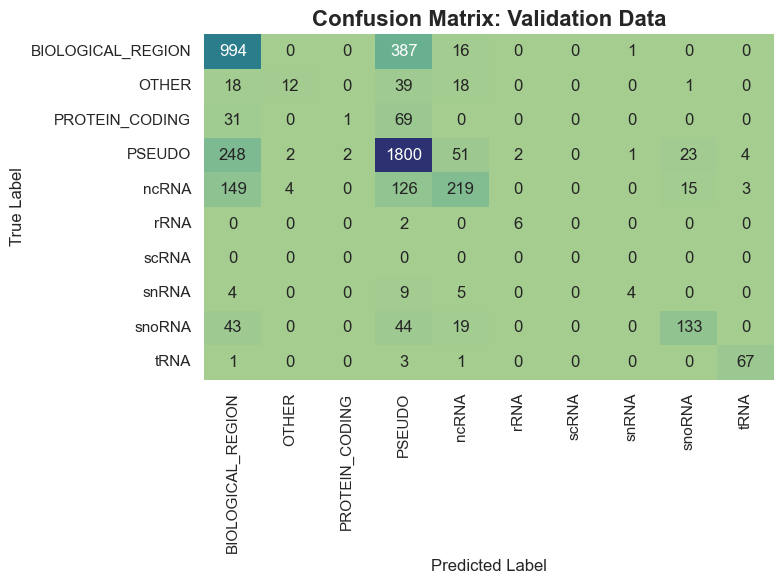

In [39]:
# ================================
# Baseline Model: GeneType Prediction
# ================================

# Task: Predict 'GeneType' from raw DNA sequences using character-level n-grams.
# Approach: TfidfVectorizer (char-level, n=3 to mimic codon-like structures) + Logistic Regression.

pipeline = make_pipeline(
    TfidfVectorizer(analyzer='char', ngram_range=(3, 3)),
    LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='auto')
)

# Train the baseline model
pipeline.fit(train_df['NucleotideSequence'], train_df['GeneType'])

# Validation predictions
val_predictions = pipeline.predict(val_df['NucleotideSequence'])

# Evaluate accuracy
accuracy = accuracy_score(val_df['GeneType'], val_predictions)
print('-----------------------------------------------------------------------------------------------------------------------')
print(f"Validation Accuracy: {accuracy:.3f}")

# Confusion matrix visualization
cm = confusion_matrix(val_df['GeneType'], val_predictions, labels=pipeline.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='crest', 
    xticklabels=pipeline.classes_, 
    yticklabels=pipeline.classes_,
    cbar=False
)

plt.title('Confusion Matrix: Validation Data', fontsize=16, weight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

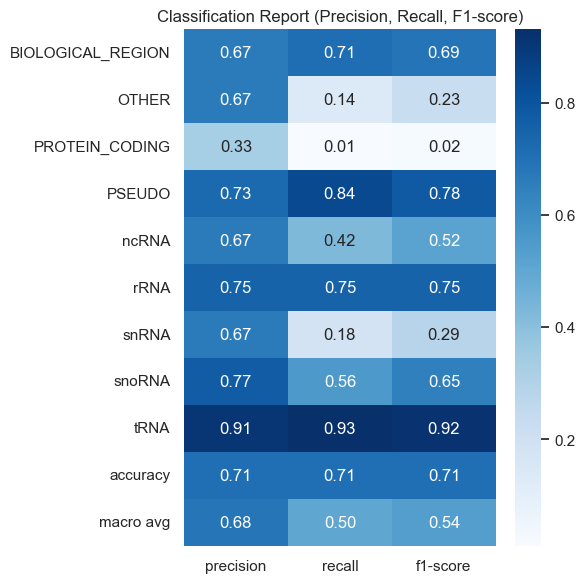

c:\Users\muham\miniconda3\envs\py\Lib\site-packages\sklearn\metrics\_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


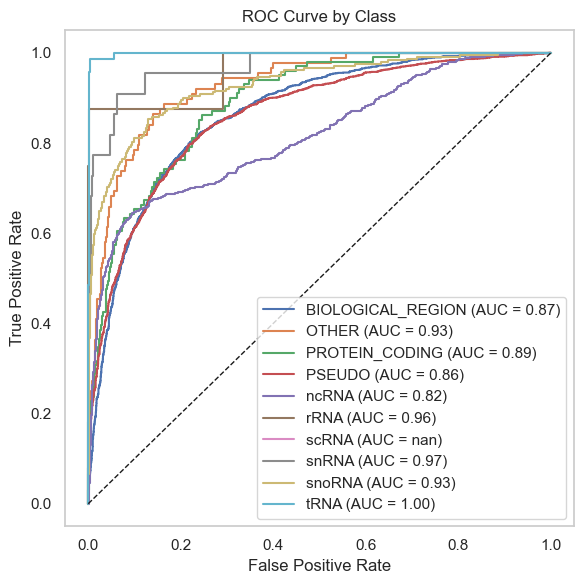

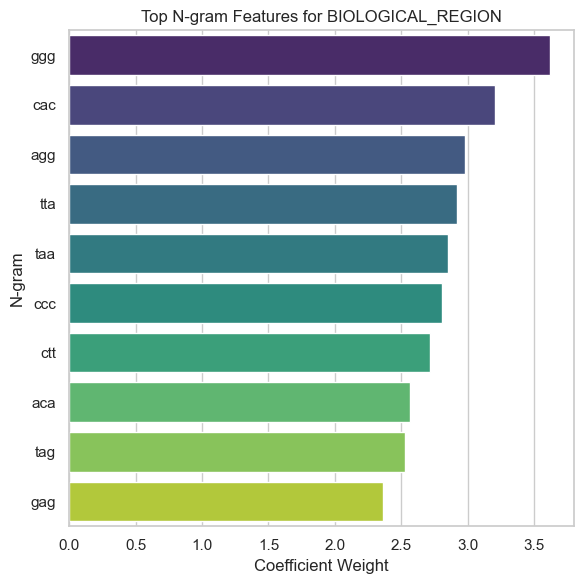

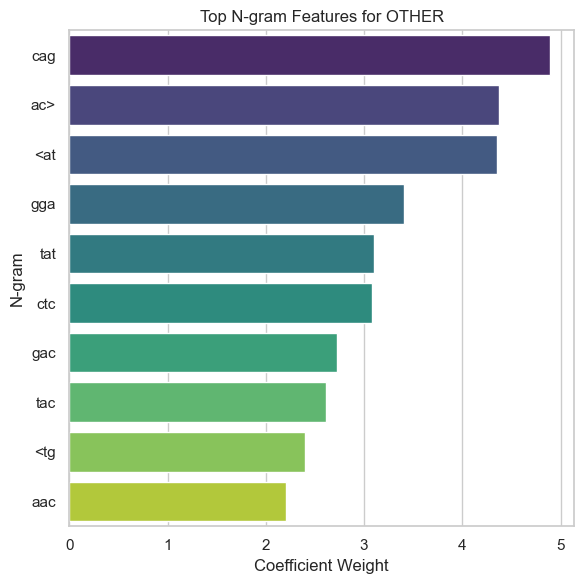

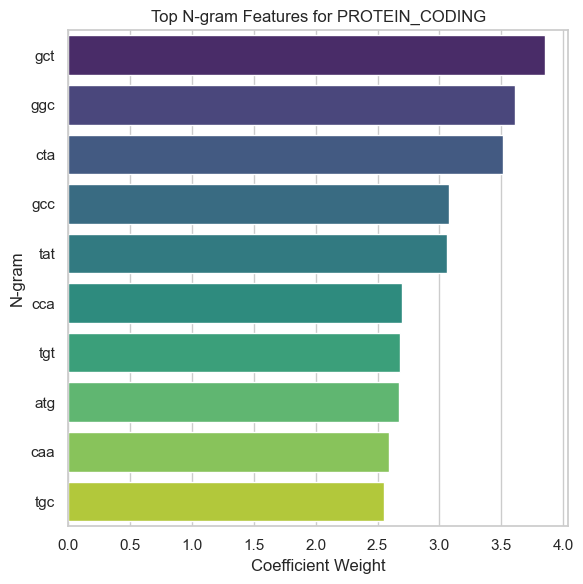

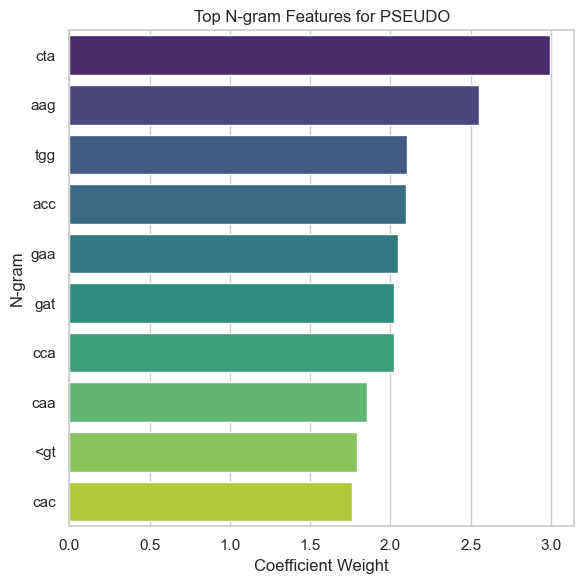

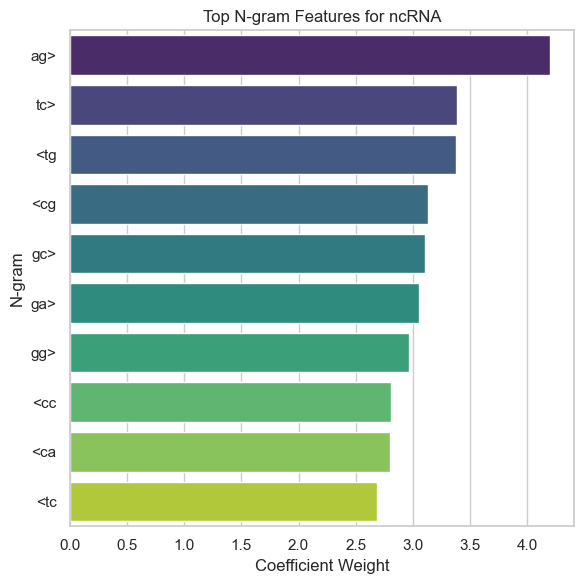

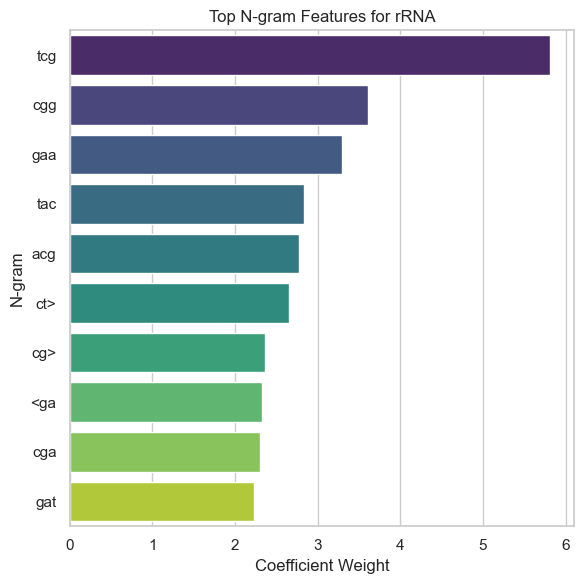

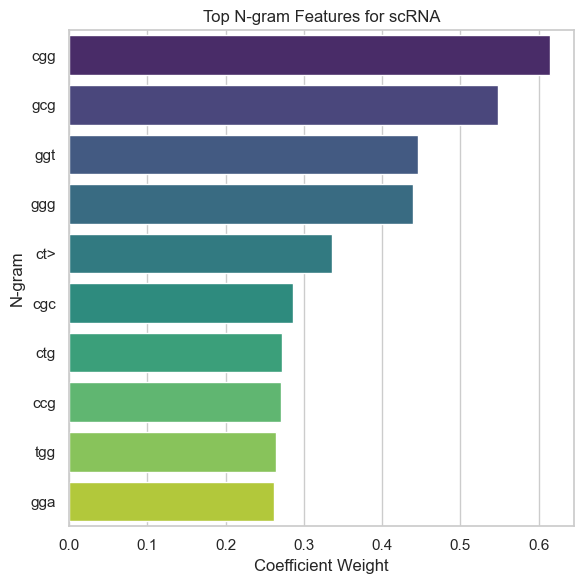

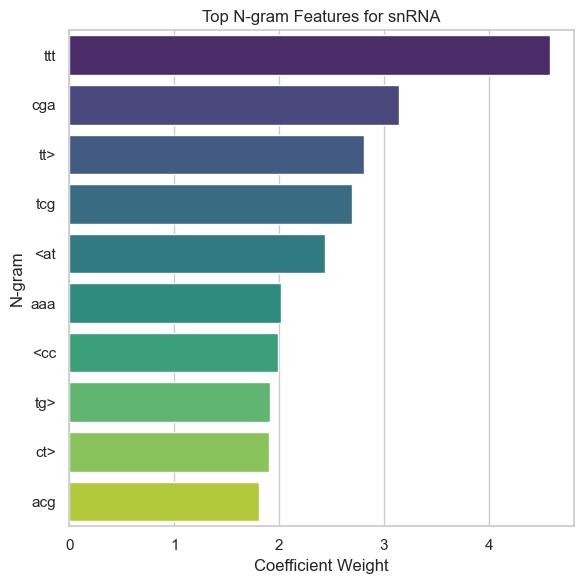

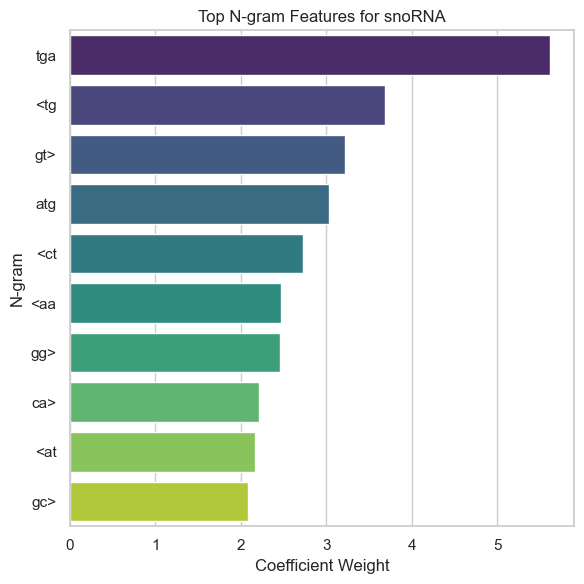

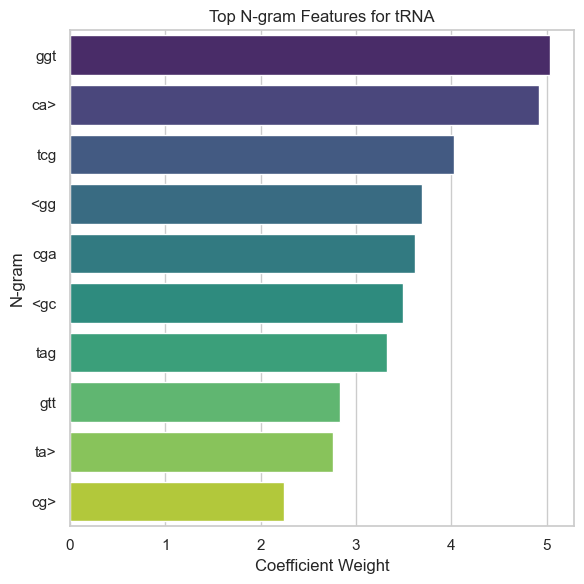

In [62]:
# --- Classification Report as Table ---
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(val_df['GeneType'], val_predictions, output_dict=True)
report_df = pd.DataFrame(report).transpose()
plt.figure(figsize=(6, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt='.2f')
plt.title('Classification Report (Precision, Recall, F1-score)')
plt.tight_layout()
plt.show()

# --- ROC Curve for Each Class ---
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the output
y_true_bin = label_binarize(val_df['GeneType'], classes=pipeline.classes_)
y_pred_prob = pipeline.predict_proba(val_df['NucleotideSequence'])

plt.figure(figsize=(6, 6))
for i, class_name in enumerate(pipeline.classes_):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by Class')
plt.legend(loc='lower right')
plt.tight_layout()
plt.grid(False)
plt.show()

# --- Feature Importance (Top N-grams) ---
vectorizer = pipeline.named_steps['tfidfvectorizer']
clf = pipeline.named_steps['logisticregression']
feature_names = vectorizer.get_feature_names_out()
for idx, class_name in enumerate(clf.classes_):
    top_indices = clf.coef_[idx].argsort()[-10:][::-1]
    top_features = feature_names[top_indices]
    top_weights = clf.coef_[idx][top_indices]
    plt.figure(figsize=(6, 6))
    sns.barplot(
    x=top_weights,
    y=top_features,
    hue=top_features,   # use the feature names as hue
    dodge=False,        # avoid double bars
    palette='viridis',
    legend=False)
    plt.title(f'Top N-gram Features for {class_name}')
    plt.xlabel('Coefficient Weight')
    plt.ylabel('N-gram')
    plt.tight_layout()
    plt.show()

In [35]:
# ================================
# Notes & Future Directions
# ================================
# 1. This is a baseline predictor using TF-IDF + Logistic Regression.
# 2. Potential improvements:
#    - Hyperparameter tuning (regularization strength, solver, etc.).
#    - Alternative text embeddings (k-mer counts, word2vec-style embeddings for sequences).
#    - Advanced classifiers (SVM, Random Forest, or deep learning models like CNNs for sequence data).
# 3. Preprocessing options:
#    - Cleaning unusual characters in sequences.
#    - Normalizing sequence lengths.

### Conclusion
In this notebook we explored a dataset of DNA sequences and built a classification model to predict gene types from nucleotide sequences. Our approach leveraged character-level n-grams to capture meaningful patterns from the sequences and a logistic regression classifier as a baseline predictor